Types:

**Point Anomalies.** If an individual data instance can be considered as anomalous with respect to the rest of the data (e.g. purchase with large transaction value)


**Contextual Anomalies**, If a data instance is anomalous in a specific context, but not otherwise ( anomaly if occur at certain time or certain region. e.g. large spike at middle of night)


**Collective Anomalies**. If a collection of related data instances is anomalous with respect to the entire data set, but not individual values. They have two variations.
Events in unexpected order ( ordered. e.g. breaking rhythm in ECG)
Unexpected value combinations ( unordered. e.g. buying large number of expensive items)


https://www.cse.wustl.edu/~jain/cse567-17/ftp/mttad/index.html


https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561


https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/


ONE CLASS CLASSIFICATION :

Feature Boundaries Detector for One-Class Classification FBDOCC method[Jun],

One-class SVM,

Least Squares One-class SVM, 

Kernel PCA,

Gaussian Process Prior OCC, 

Condensed Nearest Neighbor Data Description 

One-class Random Forests.

NEAREST NEIGHBOUR BASED:

Eucledian mostly

For multi variate data instances the distance or similarity for each attributes are computed and then combined

Using distance of the K-nearest neighbor

density based


CLUSTERING BASED:

STATISTICAL ANOMALY DETECTION TECHNIQUES:

Parametric 

gaussina model based

regreesino based 

Non parametric based:
Histogrm based

HBOS algorithm

SOME OTHER TECHNIQUES:



Anamoly detection done in 4 types
1)Robust covariance errors
2)One class SVM
3)Isolation forest
4) Local Outlier Factor

depending on the distribution of the data and the data.

the above ones are most suited for clusters



-------------------------------

Other techniques for time series kind of data

- low-pass filter
- Moving Average Using Discrete Linear Convolution
- rolling std dev
- stationary std dev
https://www.datascience.com/blog/python-anomaly-detection
- exponential moving average
- exponential moving std
https://machinelearnings.co/data-science-tricks-simple-anomaly-detection-for-metrics-with-a-weekly-pattern-2e236970d77
- moving median decomposition 
https://anomaly.io/anomaly-detection-moving-median-decomposition/

-----------------------------

inbuilt method:

https://github.com/HamishWoodrow/anomaly_detection/blob/master/example.ipynb


from anom_detect import anom_detect

an = anom_detect()

an.plot()

# The graph values can be accessed using 'results'.
an.results.head()

# Anomalous data points can be printed from anoma_points.
an.anoma_points.head()


What is ESD test ?
ARIMA 


Evaluate for Anomalies
There are a number of options available in the anom_detect method. It is recommended a small description below helps to:

method : This is the data filtering method used, for the moment only 'average' is avaiable representing the moving average method. In the future more data modelling techniques will be implemented.
max_outliers : This is defaulted to 'None', which means that the max number of outliers is set to the size of your data set. For more efficient computation this should be limited.
window : The window size for the moving average, defaulted to 5.
alpha : the significance level used for ESD test.
mode : Method used in discrete linear convolution for dealing with boudaries. Please read seperate documentation. Default is 'same', this means that the window of averaging must intersect with data points with a length of >len(window)/2


http://scikit-learn.org/stable/modules/outlier_detection.html


http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html

This is the for the rolling thing to detect anamolies

In [5]:
from google.colab import files
uploaded = files.upload()

Saving sunspots.txt to sunspots.txt


In [0]:
import pandas as pd
from __future__ import division
from itertools import count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

In [0]:
data = pd.read_csv('sunspots.txt',sep='\t', header = None)

In [0]:
# 3. Lets define some use-case specific UDF(User Defined Functions)

def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')


def explain_anomalies(y, window_size, sigma=1.0):

  avg = moving_average(y, window_size).tolist()
  residual = y - avg
  # Calculate the variation in the distribution of the residual
  std = np.std(residual)
  return {'standard_deviation': round(std, 3),
          'anomalies_dict': collections.OrderedDict([(index, y_i) for
                                                     index, y_i, avg_i in zip(count(), y, avg)
            if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}


def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in zip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}


# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].iterkeys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].itervalues(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

AttributeError: ignored

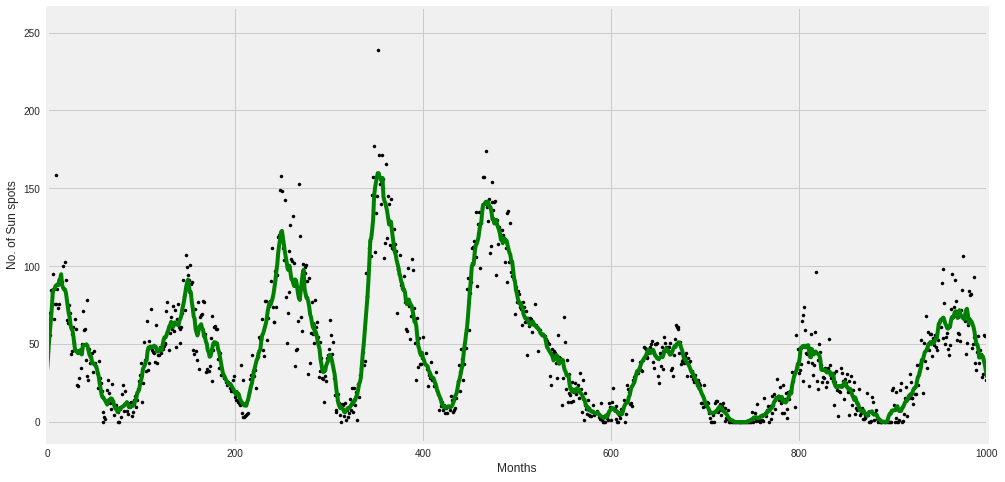

In [19]:
plot_results(data[0], y=data[1], window_size=10, text_xlabel="Months", sigma_value=3,
             text_ylabel="No. of Sun spots")
events = explain_anomalies(y, window_size=5, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(events))

In [0]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

In [0]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


In [11]:
print(__doc__)

rng = np.random.RandomState(42)

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]


Automatically created module for IPython interactive environment


In [0]:
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples,
                                        contamination=outliers_fraction,
                                        random_state=rng),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=35,
        contamination=outliers_fraction)}

In [0]:
# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

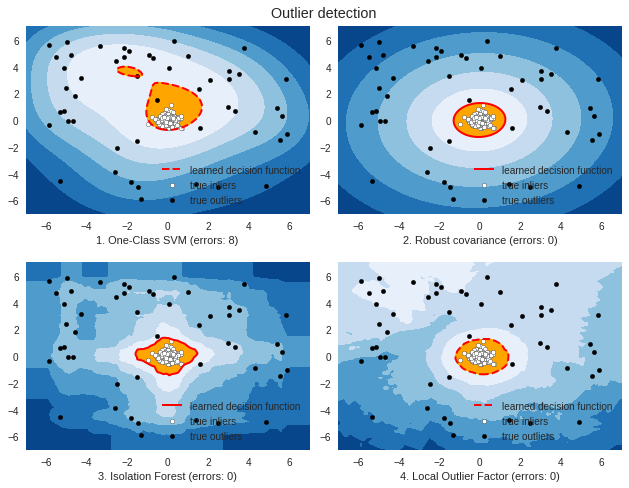

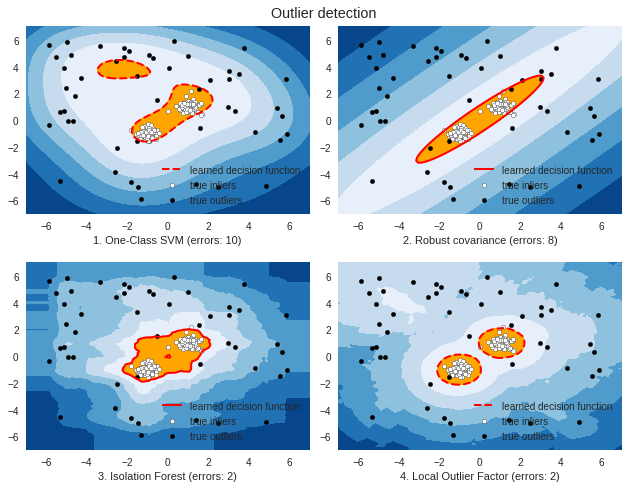

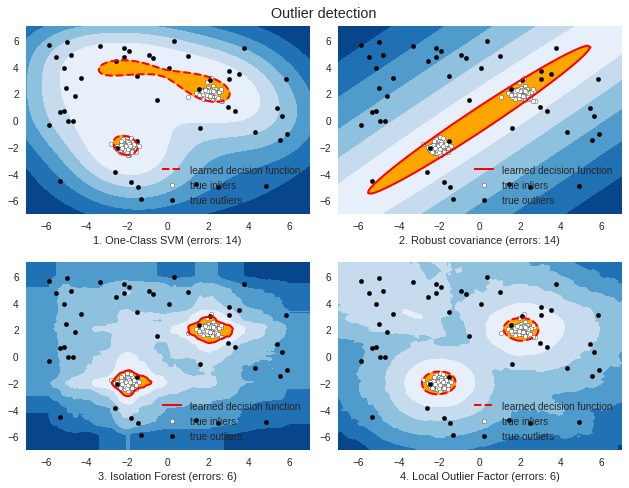

In [6]:
# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(9, 7))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        if clf_name == "Local Outlier Factor":
            y_pred = clf.fit_predict(X)
            scores_pred = clf.negative_outlier_factor_
        else:
            clf.fit(X)
            scores_pred = clf.decision_function(X)
            y_pred = clf.predict(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        if clf_name == "Local Outlier Factor":
            # decision_function is private for LOF
            Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(2, 2, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")

In [0]:
plt.show()